In [1]:
using ConvDiffMIPDECO
using PyPlot
using jInv.Mesh
using jInv.ForwardShare
using jInv.InverseSolve
using jInvVis
using jInv.LinearSolvers
using MAT

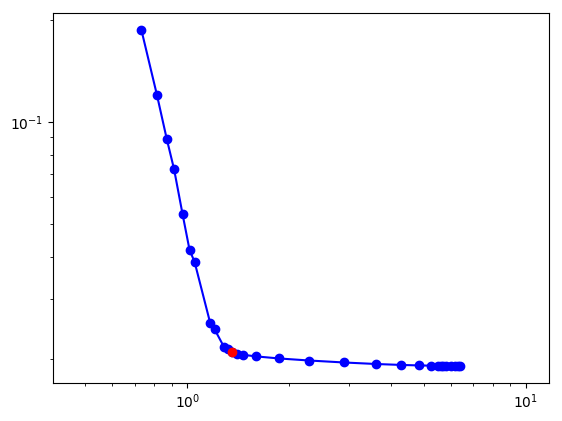

0.005298316906283708

In [3]:
# read results from l-curve
dataset    = "Sources3D"
reg        = "wTVReg"
m          = [96 48 48]
noiseLevel = 0.1


data = matread("$(dataset).mat")
domain = data["domain"]
v      = data["v"]
sig    = data["sig"]  
dtrue  = data["dtrue"]
rec    = data["rec"];
mf     = round.(Int64,data["m"])

M = getRegularMesh(domain,m)

resFile = "results/$(dataset)-$(reg)-noise-$(noiseLevel)-$(m[1])x$(m[2])x$(m[3]).mat"
res = matread(resFile)
dobs = res["dobs"]

idx = 12;
loglog(res["Reg"],res["Mis"],"-ob")
loglog(res["Reg"][idx],res["Mis"][idx],"-or")
axis("equal")

alpha = res["alphas"][idx]


In [4]:
# build inverse problem
Mfine = getRegularMesh(domain,vec(data["m"]));
x1c,x2c,x3c = getCellCenteredAxes(Mfine)
rec3D = [kron(ones(length(x3c)),rec) kron(x3c,ones(size(rec,1)))]
# build linear interpolation matrix from nodes to receiver locations
x1,x2,x3 = getNodalAxes(M)
P = interpmat(x1,x2,x3, rec3D);

pFor = getConvDiffFEMParam(M,v=v,sig=sig,P=P,Ainv=getMUMPSsolver());

## configure misfit
Wt         = ones(size(dobs))/sqrt(mf[3])          
sigback    = 0.0
pMis       = getMisfitParam(pFor,Wt,dobs,SSDFun) 
	
## Configure regularization
mref       = zeros(M.nc)           
reg        = (m,mr,M,I=1.0) -> wTVReg(m,mr,M,eps=1e-8)  
# reg        = (m,mr,M,I=1.0) -> wTVReg(m,mr,M,eps=1e-8)  

## Configure optimization
maxIter    = 50
minUpdate  = 1e-3
HesPrec    = getSSORRegularizationPreconditioner(1.0,1e-15,50)
cgit       = 5 
pcgTol     = 1e-1
modFun     = identityMod
boundsLow  = 0*ones(M.nc)
boundsHigh = 1*ones(M.nc)
maxStep	   = 0.1*maximum(boundsHigh)

## store the configuration 
pInv       = getInverseParam(M,modFun,reg,alpha,mref,
                             boundsLow,boundsHigh,maxStep=maxStep,
                            pcgMaxIter=cgit,pcgTol=pcgTol,minUpdate=minUpdate,maxIter=maxIter,
                            HesPrec=HesPrec);


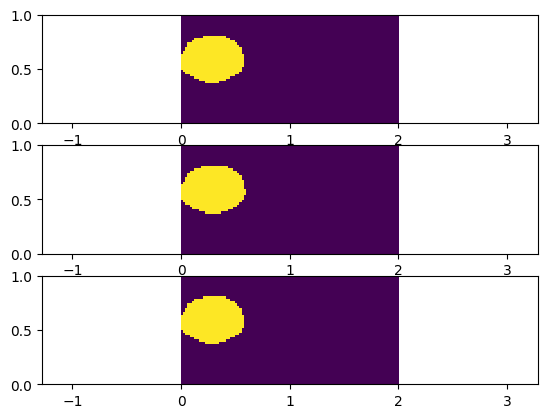

In [5]:
roundings = (s->naiveRounding(s),s->massPreservingRounding(s), s->objGapRedRounding(s,pMis,pInv))
neighborhoods = (s->trues(size(s)), s->dilation(s,pInv.MInv,1), s->dilation(s,pInv.MInv,2))

M2D = getRegularMesh(domain[1:4],m[1:2])
for k=1:length(roundings)
    subplot(length(roundings),1,k)
    src0 = reshape(roundings[k](res["Sources"][:,idx]),tuple(m...))
    viewImage2D(src0[:,:,24],M2D)
    axis("equal")
end


Trust region on entire space: MisFit, Regularizer, Total 0.02078396897699664 , 0.010938873696652036	, 0.03172284267364868
Time to compute Data term, Regularizer, and MIP: 17.162671980000002, 19.050943669999995, 0.5967223660000002 

Trust region on entire space: MisFit, Regularizer, Total 0.020797314553016085 , 0.01092244875242899	, 0.03171976330544508
Time to compute Data term, Regularizer, and MIP: 14.991393846, 17.043819662000008, 0.7362344650000001 

Trust region on entire space: MisFit, Regularizer, Total 0.020797314553016085 , 0.01092244875242899	, 0.03171976330544508
Time to compute Data term, Regularizer, and MIP: 15.084122746, 17.610830195999995, 0.840444247 

Trust region on entire space: MisFit, Regularizer, Total 0.02074941575685843 , 0.010988508026292794	, 0.031737923783151226
Time to compute Data term, Regularizer, and MIP: 19.343353309999994, 21.682786496000006, 0.63809559 

Trust region on entire space: MisFit, Regularizer, Total 0.020757136733474763 , 0.0109719030540410

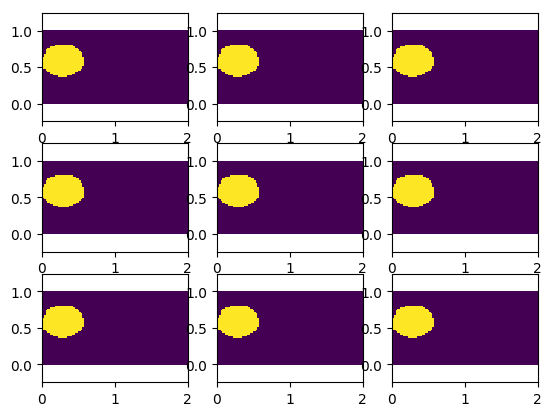

Trust region on entire space: MisFit, Regularizer, Total 0.020797314553016085 , 0.01092244875242899	, 0.03171976330544508
Time to compute Data term, Regularizer, and MIP: 15.524404971, 17.849352564999997, 0.8768669080000002 



In [9]:
nrow = length(roundings)
ncol = length(neighborhoods)
pInv.maxIter=50

results = zeros(m[1],m[2],m[3],length(roundings),length(neighborhoods))
init = zeros(m[1],m[2],m[3],length(roundings),length(neighborhoods))
His = zeros(pInv.maxIter,3,length(roundings),length(neighborhoods))
times = zeros(length(roundings),length(neighborhoods))

for k1=1:length(roundings)
    for k2=1:length(neighborhoods)
        src0 = roundings[k1](res["Sources"][:,idx])
        init[:,:,:,k1,k2] = src0
        tic()
        mcTR,DcTR,flagTR,his = mipdecoHeuristic(src0,pInv,pMis,getNeighborhood=neighborhoods[k2],out=0)
        His[:,:,k1,k2] = his;
        times[k1,k2] = toq()
        
        results[:,:,:,k1,k2] = mcTR
        subplot(nrow,ncol,k2+(k1-1)*ncol)
        viewImage2D(results[:,:,24,k1,k2],M2D)
        axis("equal")
    end
end



In [10]:
res["MIPDECO"]=results
res["MIPDECOinit"]=init
res["His"] = His
res["times"] = times

# resFirele
matwrite(resFile,res)